Mean Squared Error: 18.51061854662497


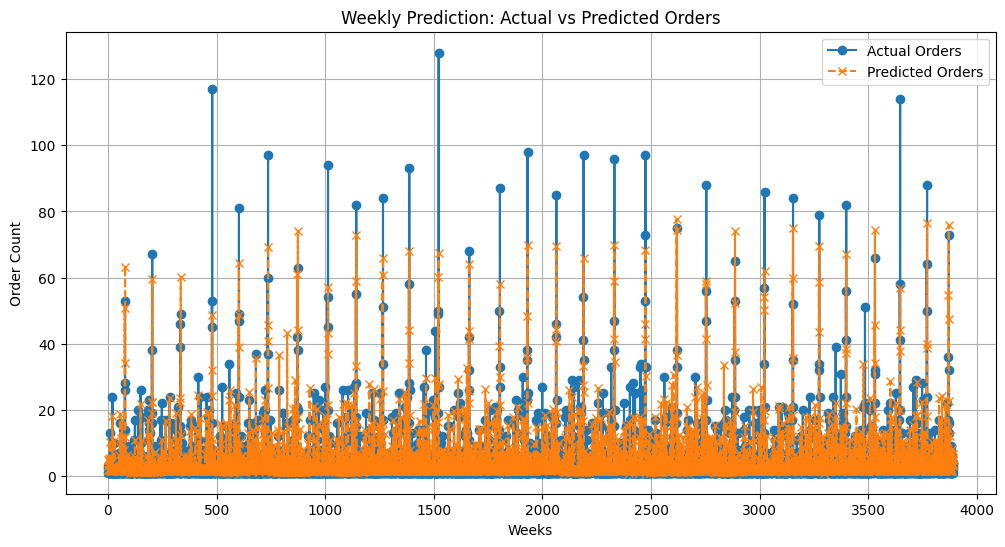

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your data
data = pd.read_csv('restaurant-1-orders.csv')

# Ensure 'Order Date' is in datetime format
# Specify format and handle potential parsing issues
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%d/%m/%Y %H:%M', errors='coerce')

# Check for invalid date entries
if data['Order Date'].isna().sum() > 0:
    print("Warning: There are invalid date entries. These will be dropped.")
    data = data.dropna(subset=['Order Date'])

# Extract week number and year from 'Order Date'
data['Week'] = data['Order Date'].dt.isocalendar().week
data['Year'] = data['Order Date'].dt.year

# Aggregate weekly order data by 'Item Name'
weekly_data = (
    data.groupby(['Year', 'Week', 'Item Name'])
    .agg({'Quantity': 'sum', 'Product Price': 'mean', 'Total products': 'sum'})
    .reset_index()
)

# Rename 'Quantity' to 'OrderCount' for clarity
weekly_data.rename(columns={'Quantity': 'OrderCount'}, inplace=True)

# Create lag feature: Previous week's order count
weekly_data['PreviousWeekOrderCount'] = (
    weekly_data.groupby('Item Name')['OrderCount'].shift(1)
)

# Fill missing values for lag features
weekly_data.fillna(0, inplace=True)

# Create target variable: Next week's order count
weekly_data['NextWeekOrderCount'] = (
    weekly_data.groupby('Item Name')['OrderCount'].shift(-1)
)

# Drop rows where target variable is missing
weekly_data.dropna(subset=['NextWeekOrderCount'], inplace=True)

# Features and target
X = weekly_data[['Week', 'OrderCount', 'PreviousWeekOrderCount']]
y = weekly_data['NextWeekOrderCount']

# Train-test split (ensure no shuffle for time-series data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test.values, label='Actual Orders', marker='o')
plt.plot(range(len(y_pred)), y_pred, label='Predicted Orders', marker='x', linestyle='--')
plt.title('Weekly Prediction: Actual vs Predicted Orders')
plt.xlabel('Weeks')
plt.ylabel('Order Count')
plt.legend()
plt.grid(True)
plt.show()
